# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

Классификация изображений: Cats vs Dogs

Обучить модель классификации изображений на 2 класса. 

Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. 

Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. 

Задание засчитывается при значениях метрики Log Loss меньше 0.3.

In [1]:
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from keras.preprocessing import image


In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [3]:
import re
import random
from random import shuffle
#from glob import glob
import glob
import numpy as np
from  scipy import ndimage
import PIL
from PIL import Image


train_files = glob.glob('../input/train/*.jpg')
test_files = glob.glob('../input/test/*.jpg')
#train_files = glob.glob('./train/*.jpg')
#test_files = glob.glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE, augmentation=True):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    if augmentation==True:
        img=img.transpose(random.choice(range(4)))     #Аугментации не было, поэтому поповорачиваем

    array = img_to_array(img)

    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path, target_size=IMG_SIZE, augmentation=False)])

In [4]:
print(len(test_files))
print(len(train_files))

12500
25000


## Визуализируем примеры для обучения

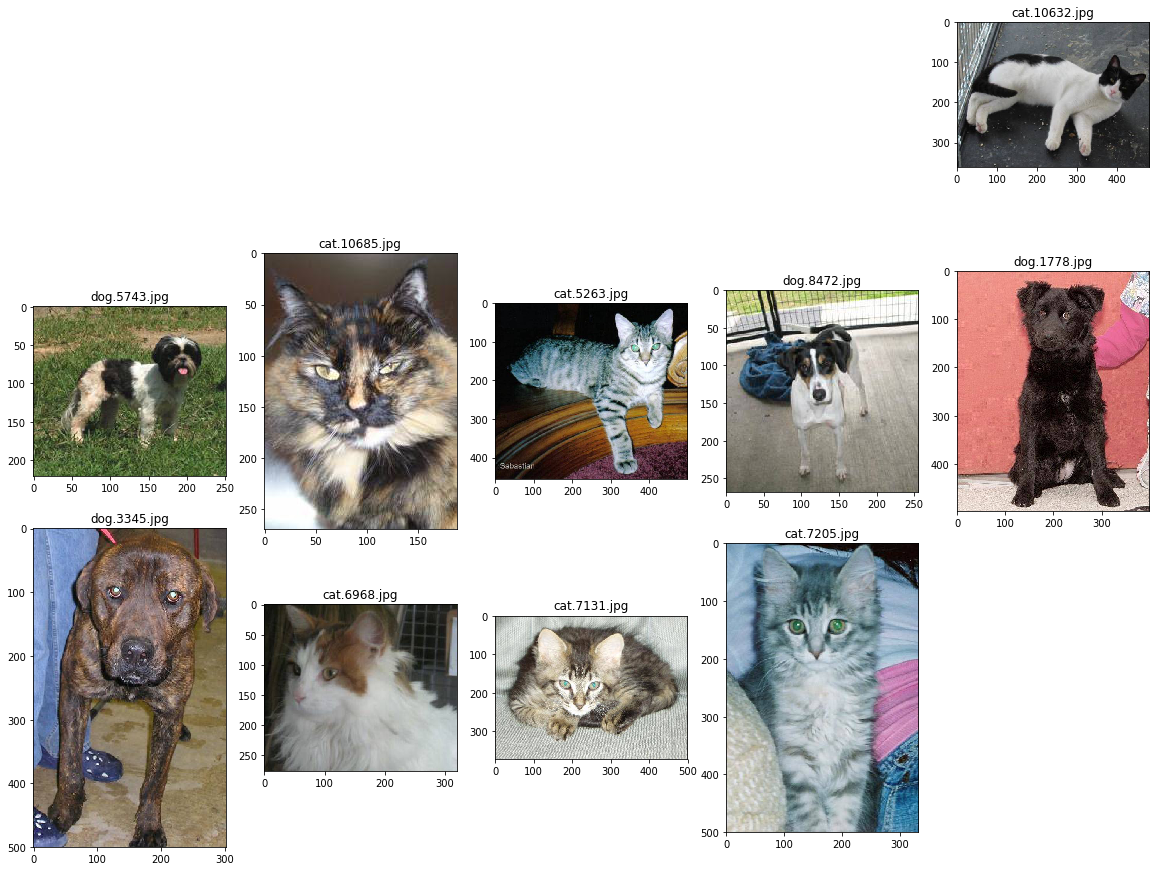

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [6]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False, #архитектура VGG16 прибита гвоздями. можно поменять
                   # из документации: whether to include the fully-connected layer at the top of the network
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

58892288/58889256 [==============================] - 6s 0us/step


In [7]:
# фиксируем все веса предобученной сети
#len(base_model.layers)=19
for layer in base_model.layers: # делаем сеть не тренируемой, можно не все слои блокировать
    layer.trainable = False

In [8]:
for layer in base_model.layers[-3:]: # последние три слоя хотел сделать тренируемыми, но как-то не задалось
    layer.trainable = True

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

![](http://)## Добавляем полносвязный слой и сверточные слои

In [10]:
x = base_model.layers[-1].output # берем выход 1 с конца слоя нашей модели (пробовал второй с конца, получил плато)
x = keras.layers.Conv2D(kernel_size = (3,3), filters = 512, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(1e-4))(x)
x = keras.layers.Conv2D(kernel_size = (5,5), filters = 256, activation='sigmoid', kernel_regularizer=keras.regularizers.l1(1e-4))(x)

x = keras.layers.Flatten()(x) # вытягиваем в вектор
x = keras.layers.Dense(1,  # добавляем один полносвязный слой
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x) # и снова обучаем эту модель

In [11]:
#for layer in base_model.layers: 
    #layer.trainable = False
#for layer in base_model.layers[-5:]: 
    #layer.trainable = True

## Выводим архитектуру модели

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Компилируем модель и запускаем обучение

In [13]:
model.compile(optimizer=keras.optimizers.Adam(lr=3e-4), #keras.optimizers.Adam(lr=0.00003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss # т.к. всего 2 класса
              metrics=['accuracy'])

In [14]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=20,  # число вызовов генератора за эпоху
        epochs=200,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/200
20/20 [==============================] - 7s 340ms/step - loss: 6.6781 - acc: 0.5578 - val_loss: 6.0519 - val_acc: 0.7400
Epoch 2/200
20/20 [==============================] - 3s 170ms/step - loss: 5.5715 - acc: 0.8516 - val_loss: 5.0893 - val_acc: 0.9200
Epoch 3/200
20/20 [==============================] - 4s 194ms/step - loss: 4.8361 - acc: 0.9062 - val_loss: 4.5540 - val_acc: 0.8800
Epoch 4/200
20/20 [==============================] - 4s 190ms/step - loss: 4.2474 - acc: 0.9094 - val_loss: 3.9996 - val_acc: 0.9100
Epoch 5/200
20/20 [==============================] - 4s 192ms/step - loss: 3.6379 - acc: 0.9344 - val_loss: 3.3224 - val_acc: 0.9600
Epoch 6/200
20/20 [==============================] - 4s 185ms/step - loss: 3.1098 - acc: 0.9531 - val_loss: 2.8569 - val_acc: 0.9400
Epoch 7/200
20/20 [==============================] - 4s 184ms/step - loss: 2.7452 - acc: 0.9312 - val_loss: 2.5724 - val_acc: 0.9300
Epoch 8/200
20/20 [==============================] - 4s 186ms/step - 

In [15]:
model.save('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [16]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

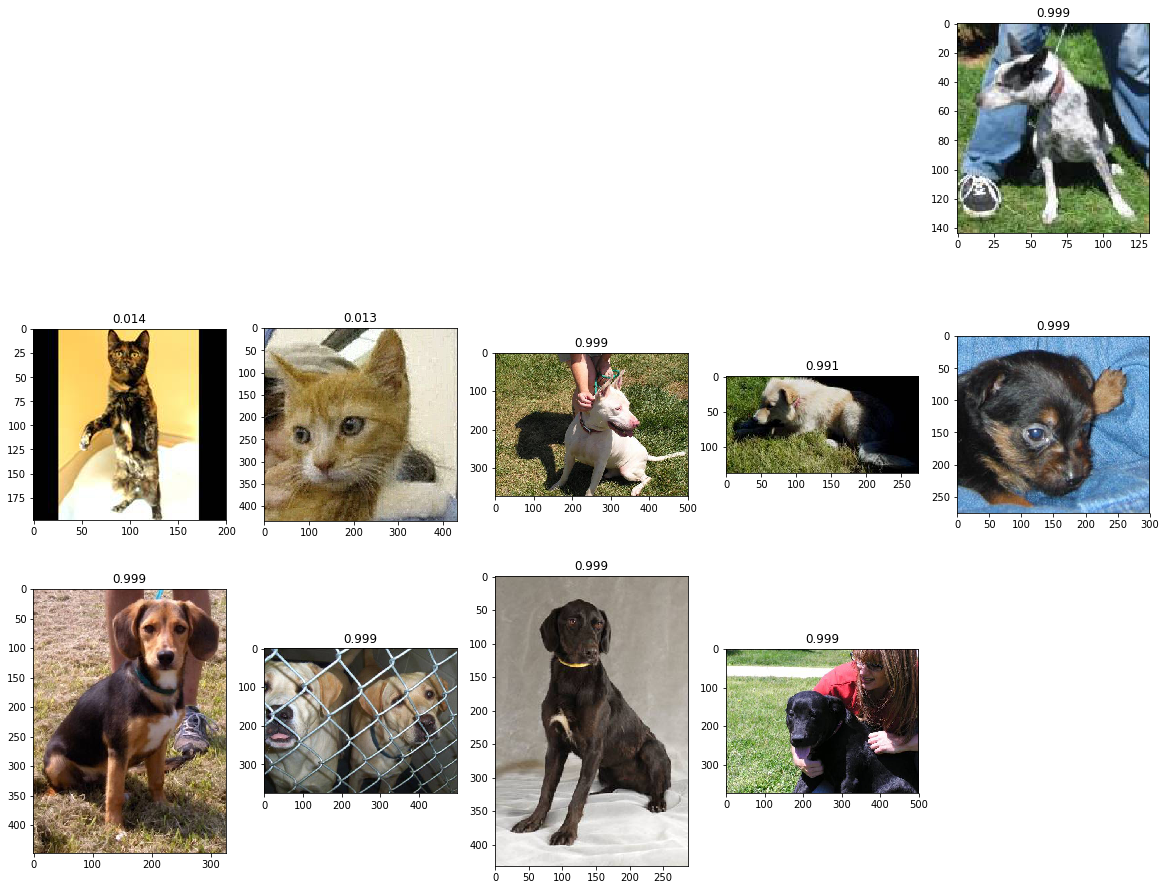

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [18]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [19]:
with open('submit_2.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [20]:
# LogLoss = 1.011

In [21]:
#pred.to_csv('submit.csv', index=False)

In [22]:
pred.shape

(12500, 1)

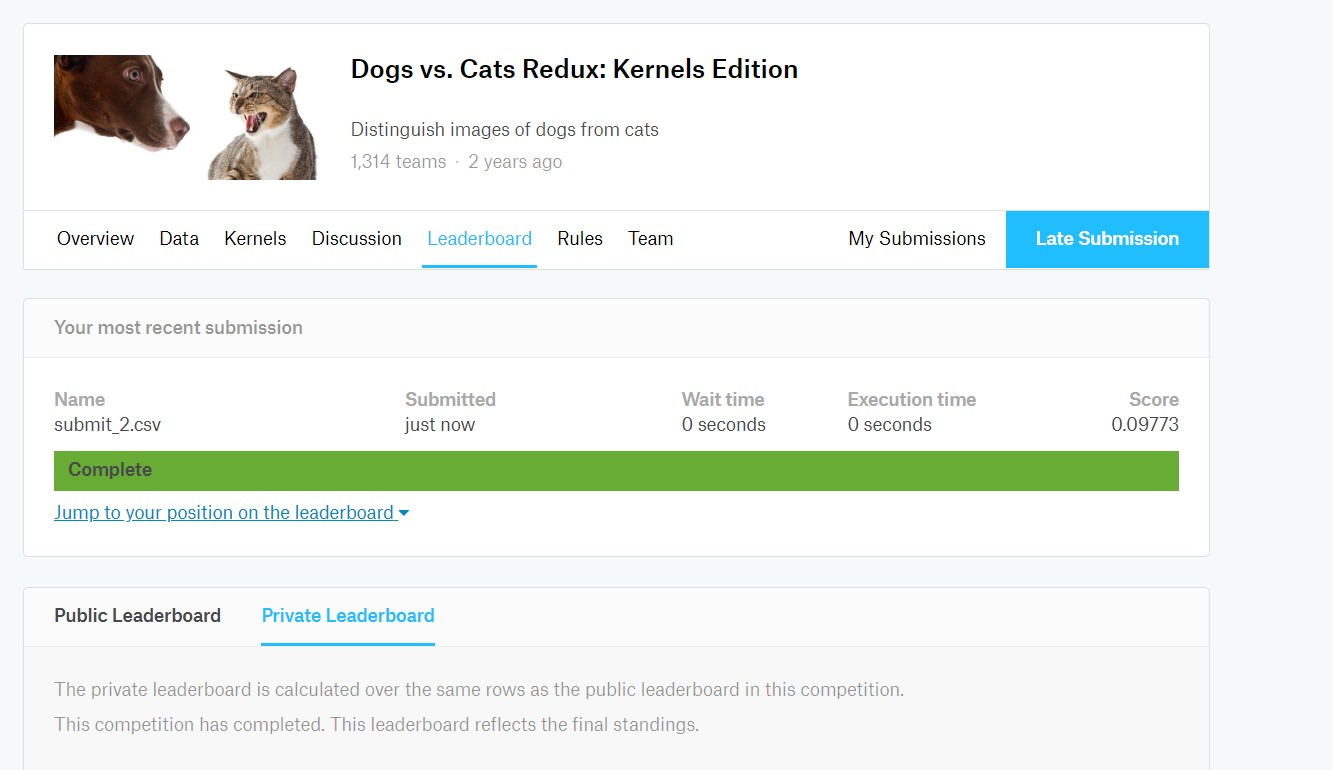

In [1]:
from IPython.display import Image
Image("Screenshot_2.jpg", width=500, height=300)